


# Does PySINDy performance vary with the level of chaos, the level of syntactic complexity, or how multi-scale the system is?

This notebook investigates a large database of chaotic systems of pure polynomial expression and polynomial degree <= 4, in order to see if the performance of PySINDy varies with the level of chaos (as measured by the largest Lyapunov exponent) or the level of syntactic complexity.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
import time

from utils import *

# Annoyingly requires the neurokit2 package - "pip install neurokit2"
from dysts.analysis import sample_initial_conditions

import pysindy as ps

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

# Chaotic System Initialization

This experiment include 77 chaotic systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [8]:
t1 = time.time()

# experimental system list
systems_list = ["Aizawa", "Arneodo", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", 
                "LorenzBounded", 
                "MooreSpiegel", "Rossler", "ShimizuMorioka",
                # Added a bunch of additional polynomial systems
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "AtmosphericRegime", "Hadley", "HindmarshRose",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]


# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "embedding_dimension",
    "parameters"
]

# Get training and testing trajectories for all the experimental systems and their attributes
n = 20000
all_sols_train = dict()
all_sols_test = dict()
all_t_train = dict()
all_t_test = dict()
all_properties = dict()

for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    print(i, eq)
    try:
        ic_train, ic_test = sample_initial_conditions(eq, 2, traj_length=1000, pts_per_period=30)
        eq.ic = ic_train
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_train[equation_name] = sol
        all_t_train[equation_name] = t_sol
        eq.ic = ic_test
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_test[equation_name] = sol
        all_t_test[equation_name] = t_sol
        attr_vals = [getattr(eq, item, None) for item in attributes]
        all_properties[equation_name] = dict(zip(attributes, attr_vals))
    except SystemError:
        print('Could not load one of the systems: ', equation_name)
    except TypeError:
        print('Could not load one of the systems ', equation_name)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Arneodo(name='Arneodo', params={'a': -5.5, 'b': 4.5, 'c': 1.0, 'd': -1.0}, random_state=None)
2 AtmosphericRegime(name='AtmosphericRegime', params={'alpha': -2.0, 'beta': -5.0, 'mu1': 0.05, 'mu2': -0.01, 'omega': 3.0, 'sigma': 1.1}, random_state=None)
3 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
4 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
5 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
6 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
7 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
8 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
9 Finance(name='Finance', params={'a': 0.001, 'b

In [9]:
num_attractors = len(systems_list)

lyap_list = []
dimension_list = []
param_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])


# Make list of the number of polynomial terms in each system1
nonlin_list = [4, 3, 3, 
               2, 2, 2, 2, 
               2, 2, 2, 3, 
               2, 2, 3, 2, 2,
               2, 3, 2, 3, 
               2, 3, 2, 2, 2,
               3, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2, 
               2, 2, 2, 3, 2, 2, 
               2, 2, 2, 2, 2, 3, 
              ]
number_nonlinear_terms = get_nonlinear_terms(num_attractors)
number_nonlinear_terms = number_nonlinear_terms[alphabetical_sort, :]
true_coefficients = make_dysts_true_coefficients(systems_list, all_sols_train, dimension_list, param_list)

## Trajectory Visualization

Took  34.6361448764801  seconds to plot the systems


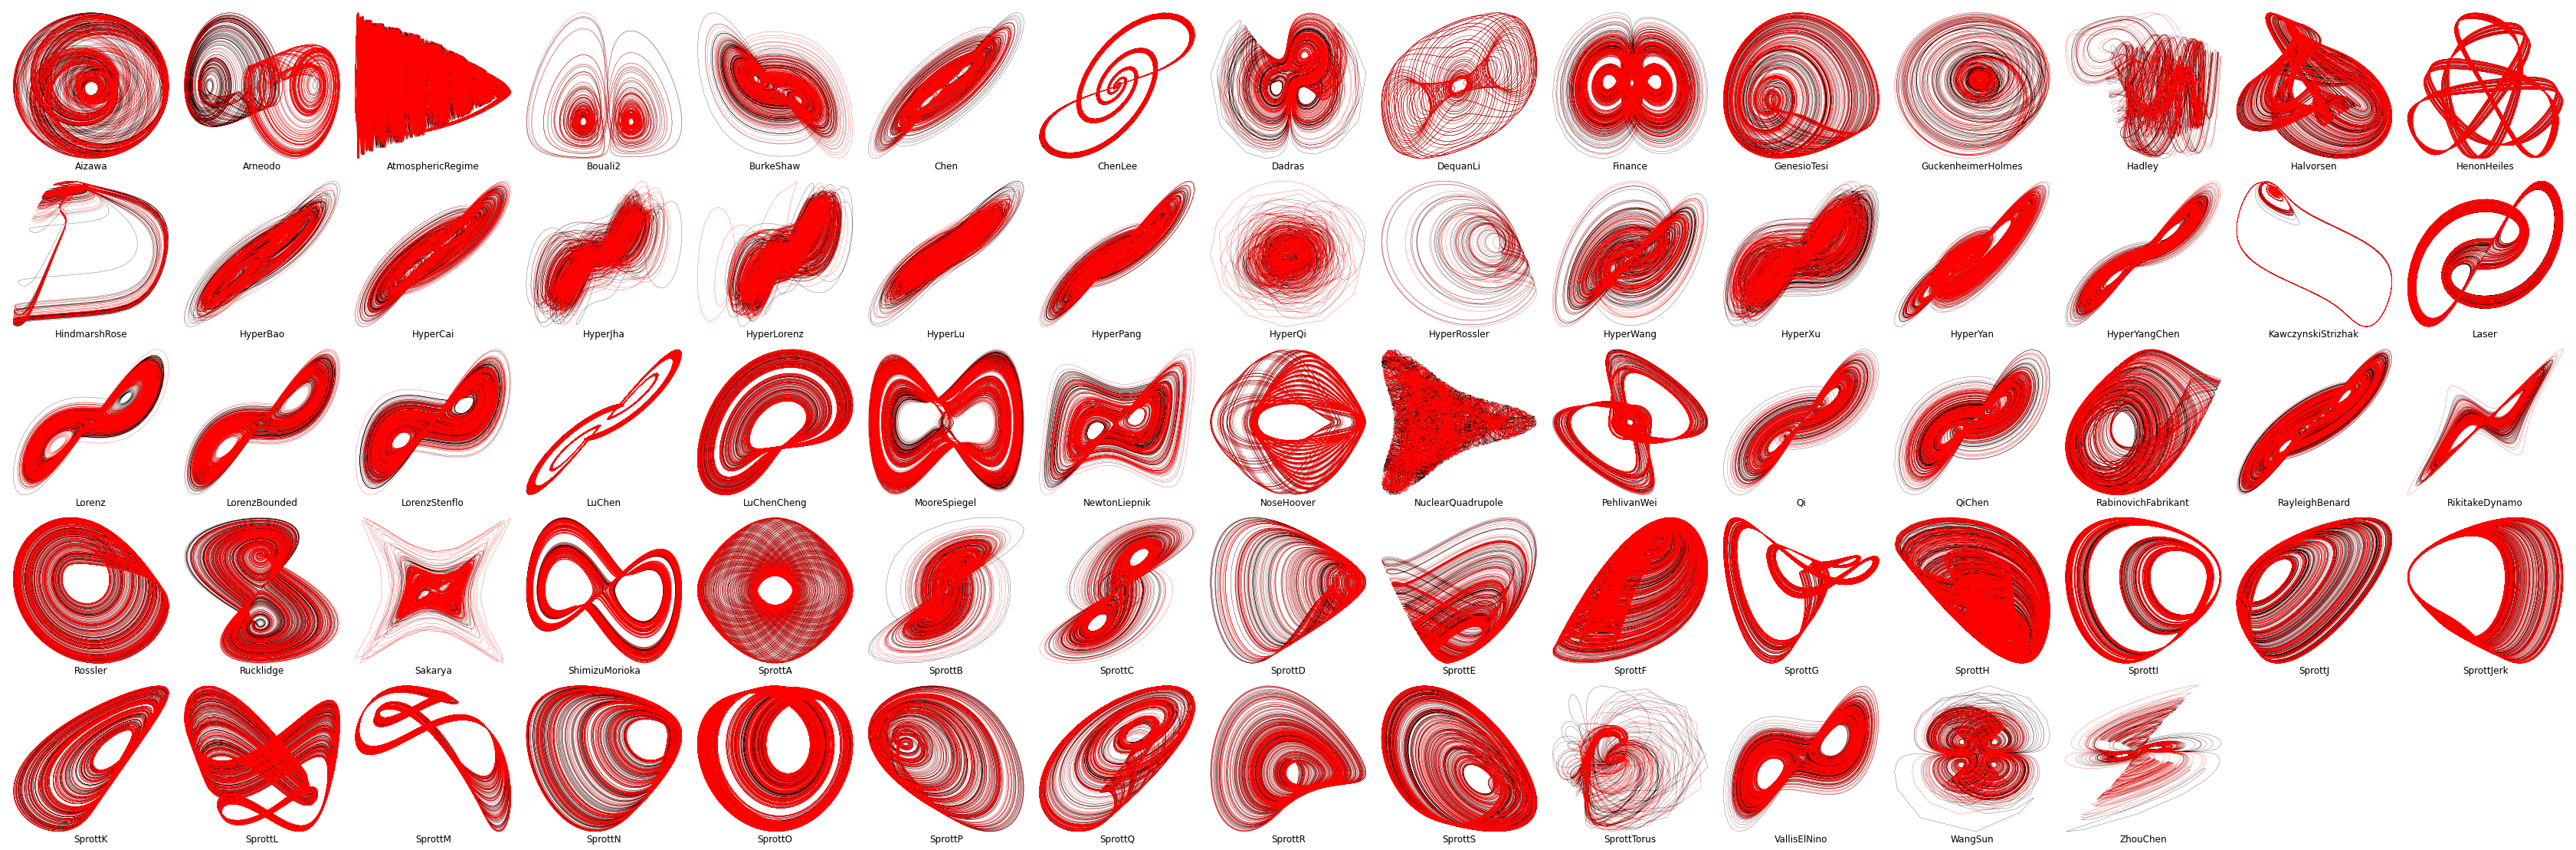

In [10]:
t1 = time.time()

# Plot the training and testing trajectories for all the chaotic systems
num_rows = 5
num_cols = int(np.ceil(len(all_sols_train) / num_rows))
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    plt.gca().axis('off')
            
plt.savefig('polynomial_attractors.jpg')
plt.savefig('polynomial_attractors.pdf')
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')

## Distribution of Chaotic Properties

Visulizes the distribution of Lyapunov exponents for the 77 chaotic systems.

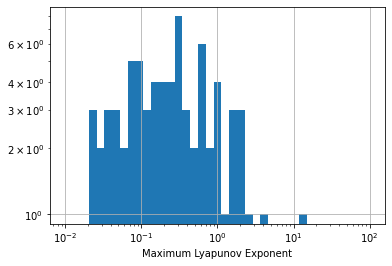

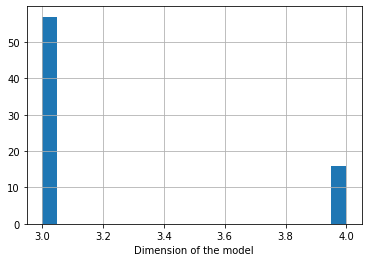

In [5]:
import matplotlib.pyplot as plt

plt.figure()

# maximum lyapunov estimated
chaotic_levels = np.logspace(-2, 2, 40)
plt.hist(lyap_list, bins=chaotic_levels, log=True)
plt.xlabel('Maximum Lyapunov Exponent')
plt.xscale('log')
plt.grid(True)

plt.figure()
plt.hist(dimension_list, bins=20)
plt.xlabel('Dimension of the model')
plt.grid(True)

# Define some metrics for performance

The normalized root-mean-square-error, the normalized coefficient errors, the success rate, and other metrics

In [6]:
def normalized_RMSE(x_dot_true, x_dot_pred):
    """
    """
    return np.linalg.norm(x_dot_true - x_dot_pred) / np.linalg.norm(x_dot_true)

def total_coefficient_error(xi_true, xi_pred):
    return np.linalg.norm(xi_true - xi_pred) / np.linalg.norm(xi_true)

def coefficient_errors(xi_true, xi_pred):
    errors = np.zeros(xi_true.shape)
    for i in range(xi_true.shape[0]):
        for j in range(xi_true.shape[1]):
            if np.isclose(xi_true[i, j], 0.0):
                errors[i, j] = abs(xi_true[i, j] - xi_pred[i, j])
            else:
                errors[i, j] = abs(xi_true[i, j] - xi_pred[i, j]) / xi_true[i, j]
    return errors

def success_rate(xi_true, xi_pred):
    print('to do')
    
#def stability_metric():

## Compute RMSEs and Normalized Errors

In [7]:
t1 = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# define data structure for records
xdot_rmse_errors = {}
xdot_coef_errors = {}
predicted_coefficients = {}

# initialize sturctures
for system in systems_list:
    xdot_rmse_errors[system] = list()
    xdot_coef_errors[system] = list()
    predicted_coefficients[system] = list()
    
# iterate over all systems and noise levels
num_fits = 5
max_iter = 100
tol_iter = 50
num_error_levels = 1
error_levels = np.linspace(0.01, 0.2, num_error_levels)
poly_library = ps.PolynomialLibrary(degree=4)

for i, attractor_name in enumerate(systems_list):
    print(i, " / ", num_attractors, ", System = ", attractor_name)

    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    # noise variance controller
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    
    for error in error_levels:
        # multiple test for averaged results
        errors_temp = []
        coef_errors_temp = []
        pred_coefs_temp = []
        for j in range(num_fits):
            # contruct noisy data
            x_train_noisy = x_train + np.random.normal(0, rmse * error, x_train.shape)
            
            # rudy train
            coef_best, err_best, coef_history, err_history, model = rudy_algorithm2(
                x_train_noisy, x_test, t_train,
                ode_lib=poly_library, dtol=1e-2,
                optimizer_max_iter=max_iter,
                tol_iter=tol_iter,
                change_factor=1.7,
                l0_pen=1e5,
                alpha=1e-5,
                normalize_columns=False
            )
            #print(coef_best)

            x_dot_test = model.differentiate(x_test, t=t_test)
            x_dot_test_pred = model.predict(x_test)
#             x_test_pred = model.simulate(x_test[0, :], t=t_test, integrator="odeint",
#                                          integrator_kws={"mxstep":30})
            errors_temp.append(normalized_RMSE(x_dot_test, x_dot_test_pred))
            coef_errors_temp.append(coefficient_errors(true_coefficients[i], coef_best))
            pred_coefs_temp.append(coef_best)
                
        # compute and record normalized errors
        #print(np.array(coef_errors_temp).shape)
        xdot_rmse_errors[attractor_name].append(np.mean(np.array(errors_temp), axis=0))
        xdot_coef_errors[attractor_name].append(np.mean(np.array(coef_errors_temp), axis=0))
        predicted_coefficients[attractor_name].append(np.mean(np.array(pred_coefs_temp), axis=0))
            
t2 = time.time()
print('Total time to compute (num_fits x num_error_levels x num_attractors = ', 
      num_fits, ' x ', num_error_levels, ' x ', num_attractors, ' = ',
      num_fits * num_error_levels * num_attractors, ') = ', t2 - t1, ' seconds')


0  /  73 , System =  Aizawa
1  /  73 , System =  Arneodo
2  /  73 , System =  AtmosphericRegime
3  /  73 , System =  Bouali2
4  /  73 , System =  BurkeShaw
5  /  73 , System =  Chen
6  /  73 , System =  ChenLee
7  /  73 , System =  Dadras
8  /  73 , System =  DequanLi
9  /  73 , System =  Finance
10  /  73 , System =  GenesioTesi
11  /  73 , System =  GuckenheimerHolmes
12  /  73 , System =  Hadley
13  /  73 , System =  Halvorsen
14  /  73 , System =  HenonHeiles
15  /  73 , System =  HindmarshRose
16  /  73 , System =  HyperBao
17  /  73 , System =  HyperCai
18  /  73 , System =  HyperJha
19  /  73 , System =  HyperLorenz
20  /  73 , System =  HyperLu
21  /  73 , System =  HyperPang
22  /  73 , System =  HyperQi
23  /  73 , System =  HyperRossler
24  /  73 , System =  HyperWang
25  /  73 , System =  HyperXu
26  /  73 , System =  HyperYan
27  /  73 , System =  HyperYangChen
28  /  73 , System =  KawczynskiStrizhak
29  /  73 , System =  Laser
30  /  73 , System =  Lorenz
31  /  73 , Sys

In [8]:
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Normalized Error

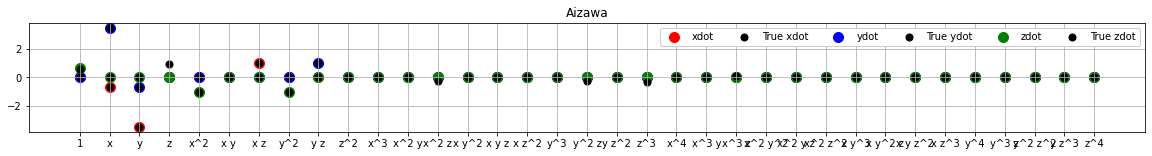

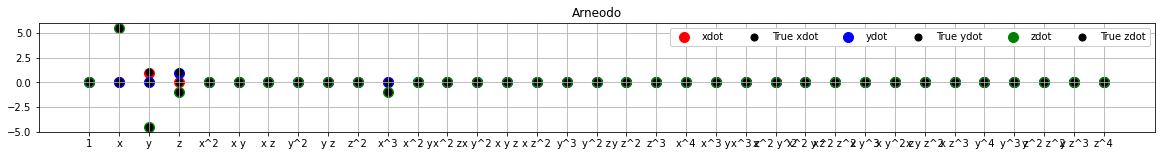

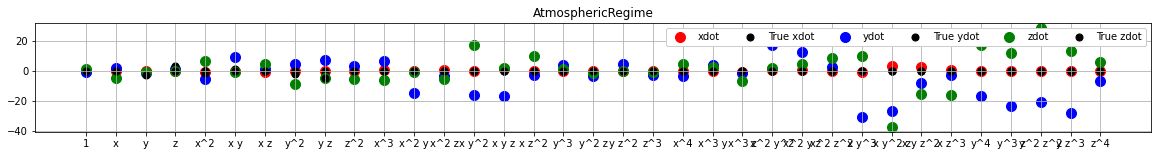

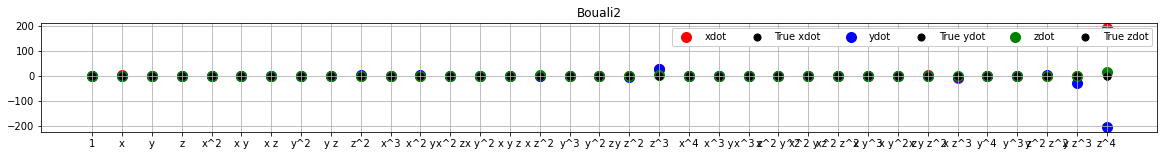

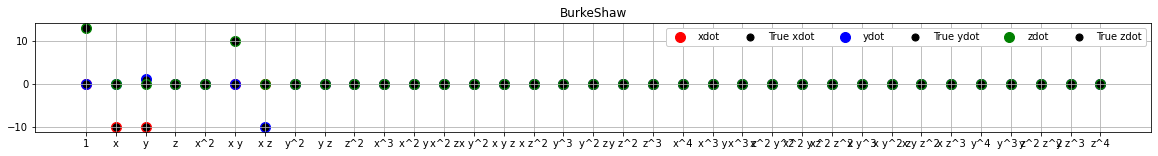

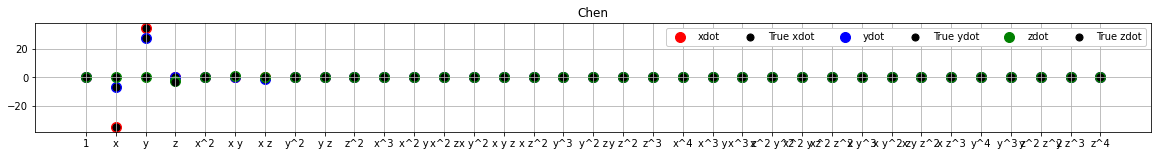

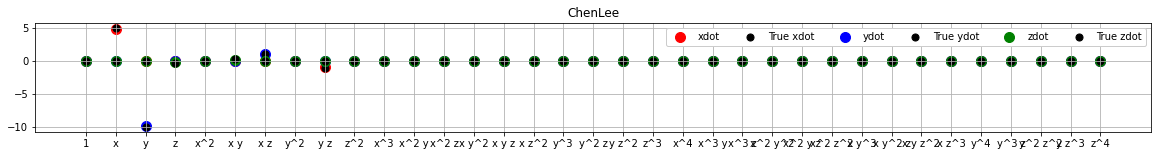

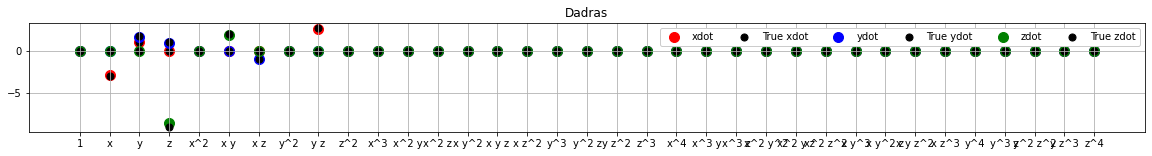

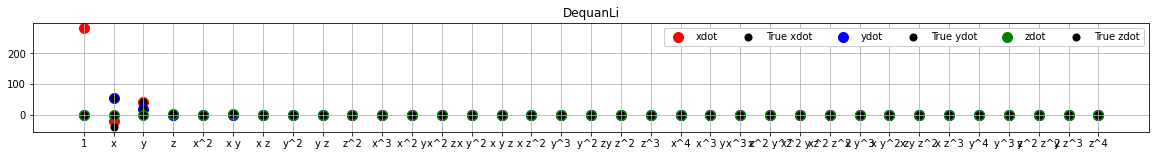

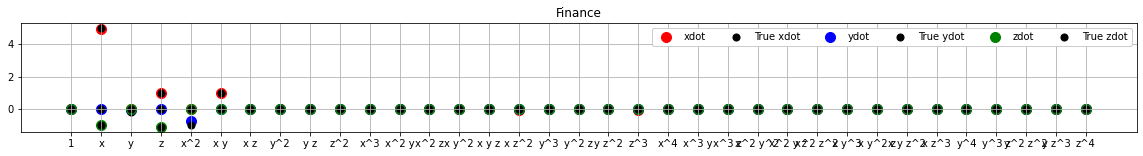

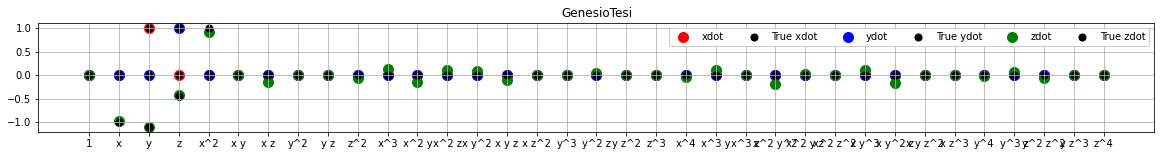

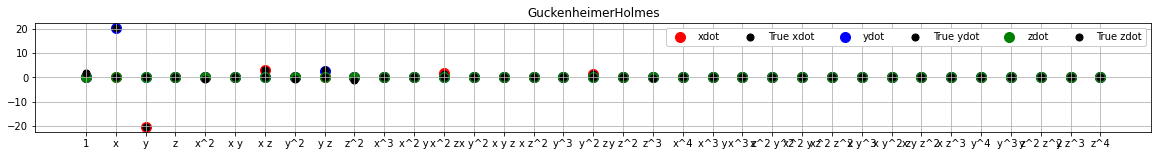

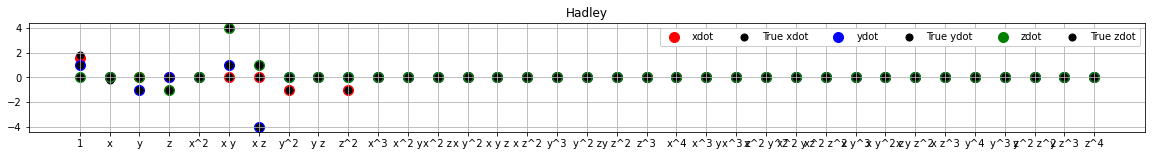

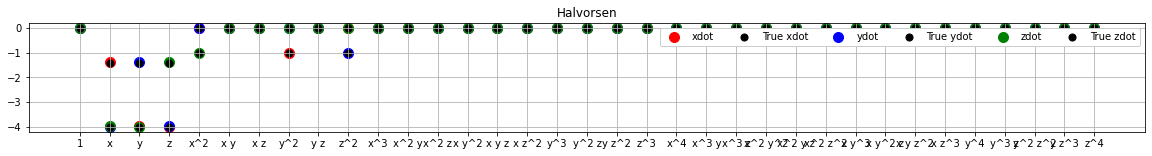

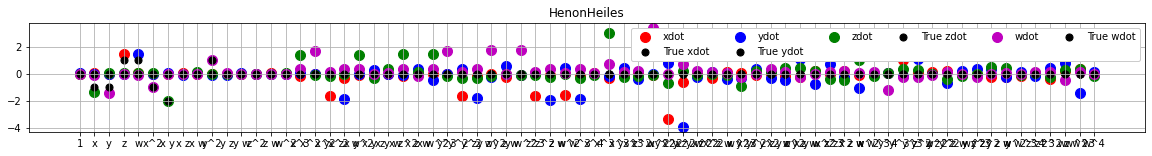

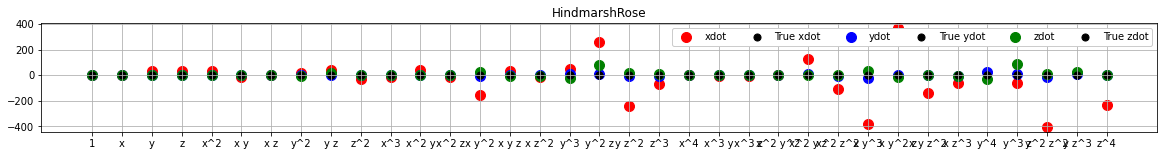

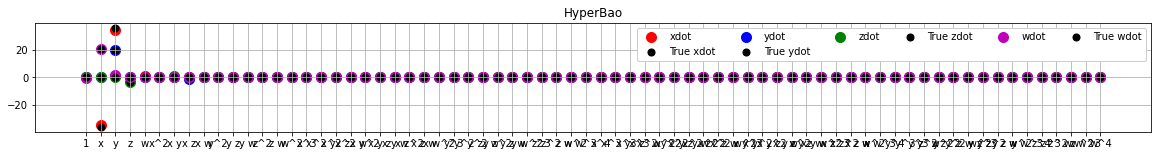

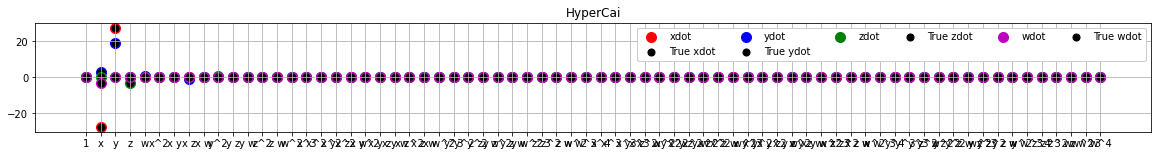

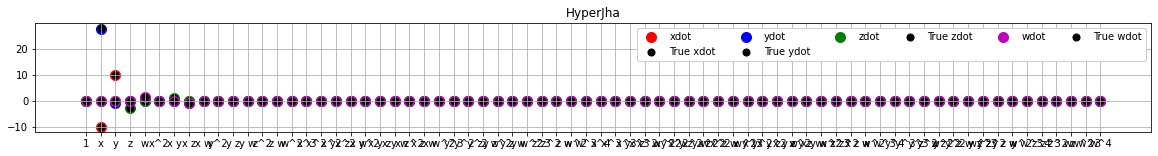

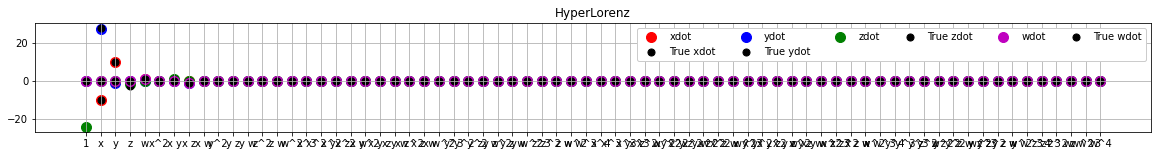

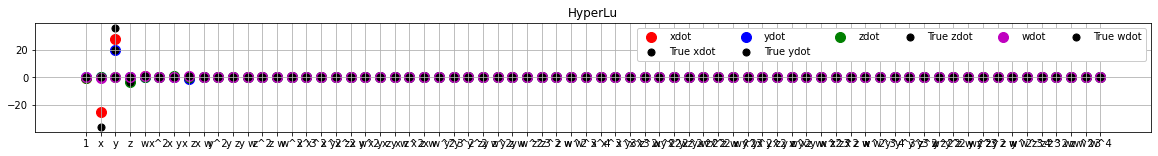

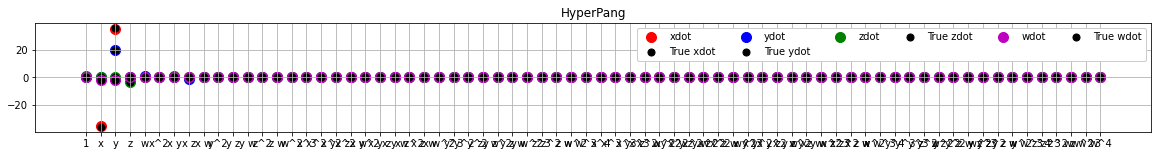

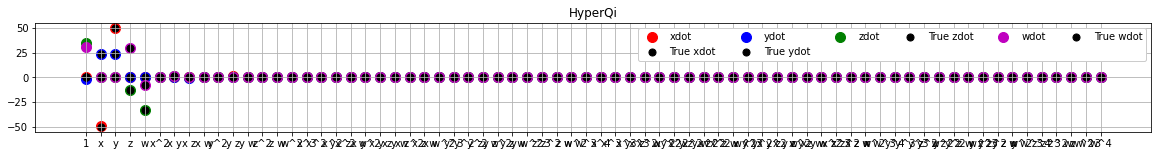

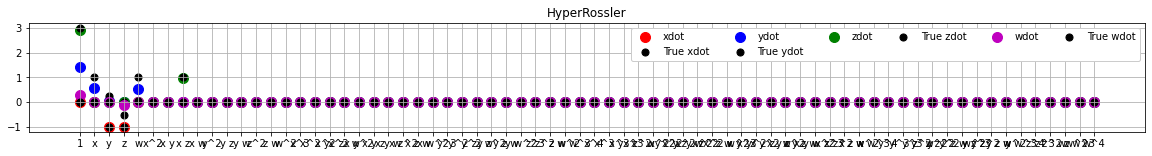

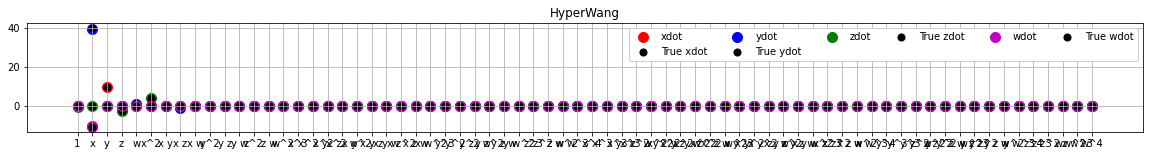

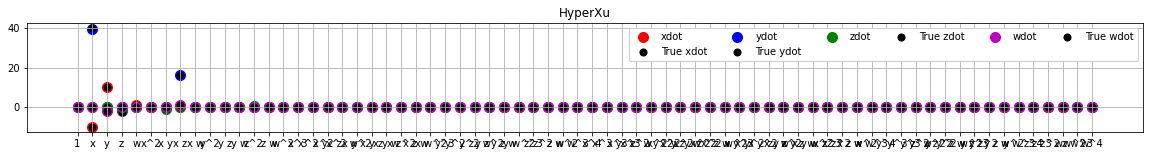

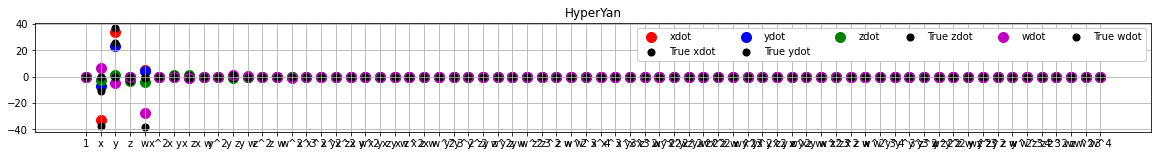

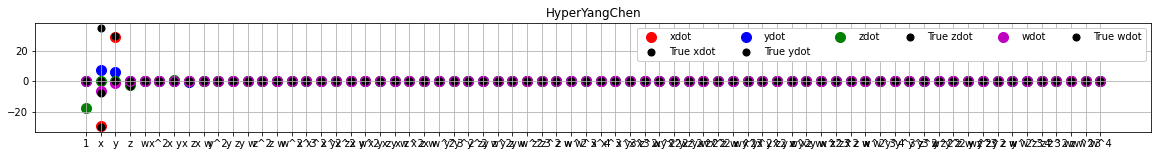

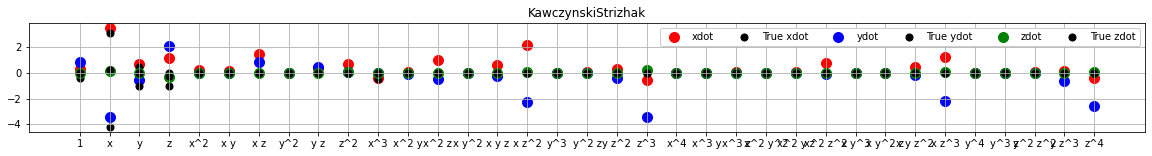

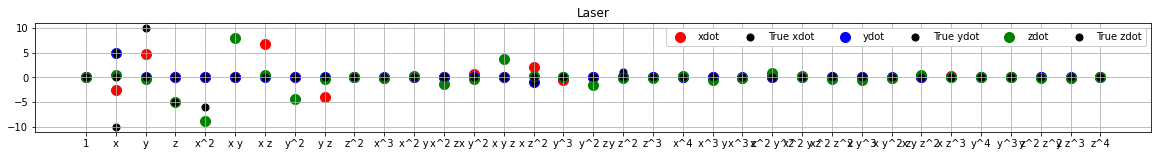

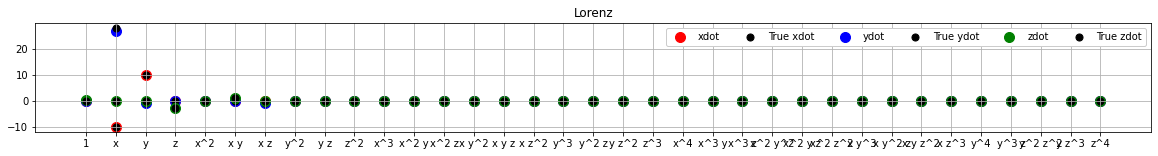

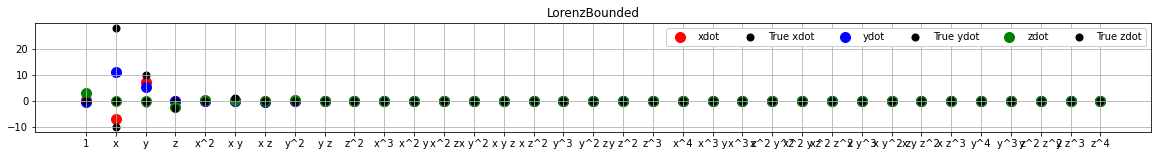

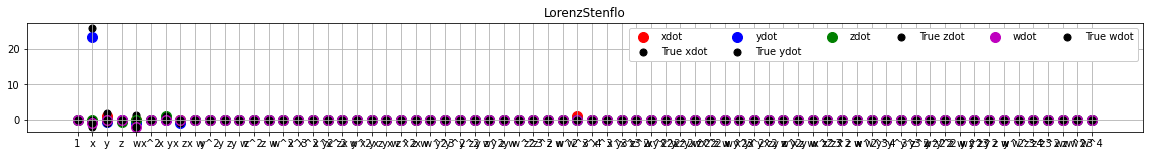

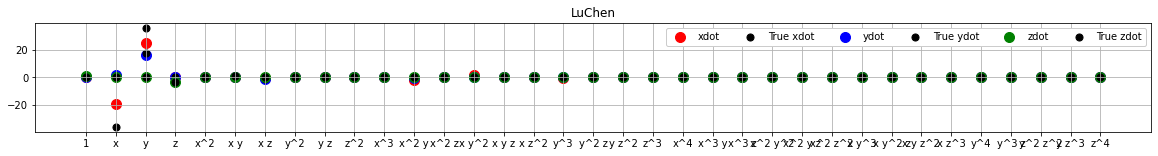

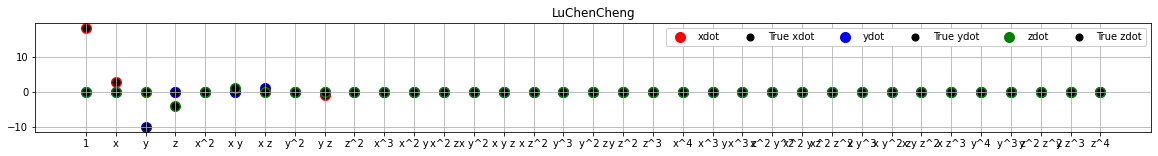

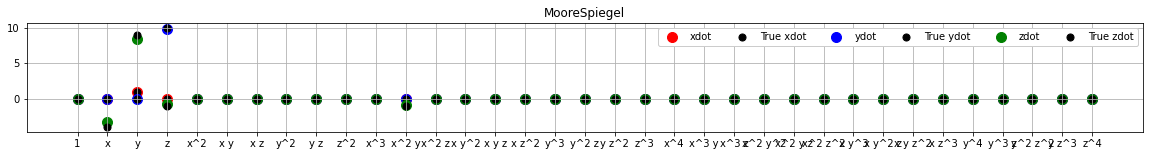

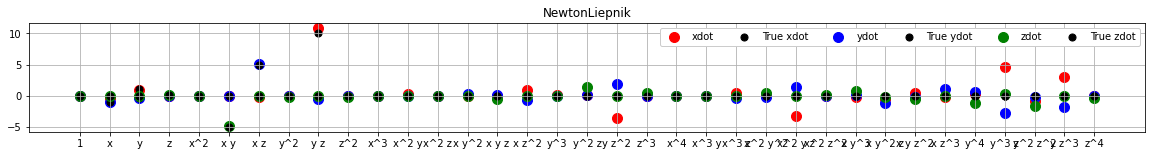

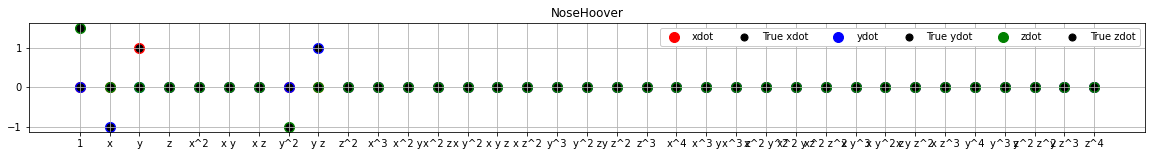

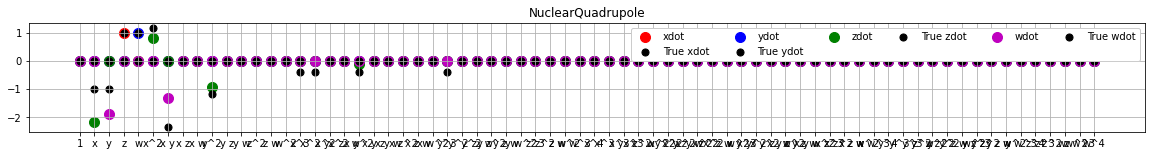

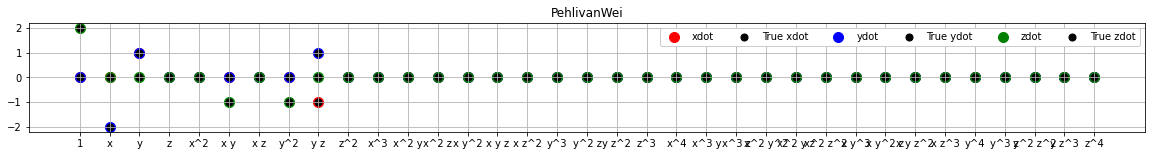

In [9]:
colors = ['r', 'b', 'g', 'm']
labels = ['xdot', 'ydot', 'zdot', 'wdot']

for i, system in enumerate(systems_list[:40]):
    x_train = all_sols_train[system]
    plt.figure(figsize=(20, 2))
    if dimension_list[i] == 3:
        feature_names = poly_library.fit(x_train).get_feature_names(['x', 'y', 'z'])
    else:
        feature_names = poly_library.fit(x_train).get_feature_names(['x', 'y', 'z', 'w'])
    for k in range(dimension_list[i]):
        #print(i, k, system, dimension_list[i])
        plt.grid(True)
        plt.scatter(feature_names, np.array(predicted_coefficients[system])[0, k, :], 
                        color=colors[k], label=labels[k], s=100)
        plt.scatter(feature_names, np.array(true_coefficients[i][k, :]), 
                        color='k', label='True ' + labels[k], s=50)
    if dimension_list[i] == 3:
        plt.legend(loc='upper right', framealpha=1.0, ncol=6)
    else:
        plt.legend(loc='upper right', framealpha=1.0, ncol=8)
    plt.title(system)
    plt.legend(loc='upper right', framealpha=1.0, ncol=6)


# Now repeat for syntactic complexity
First definition we will try is a very simple one... simply count the number of nonzero terms in the governing equations. We will make a histogram of the resulting complexity of each system.

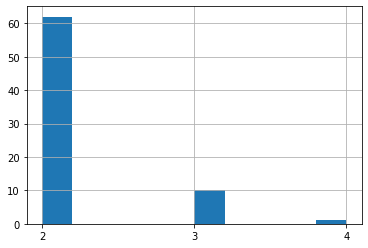

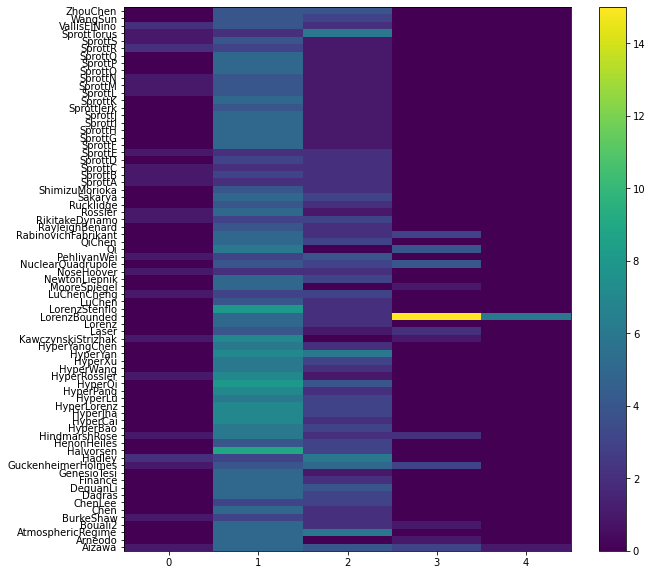

In [10]:

plt.figure()
plt.hist(nonlin_list)
plt.xticks([2, 3, 4])
plt.grid(True)

plt.figure(figsize=(10, 10))
plt.imshow(number_nonlinear_terms, aspect='auto', origin='lower')
plt.yticks(np.arange(num_attractors))
ax = plt.gca()
ax.set_yticklabels(systems_list)
plt.colorbar()
plt.show()

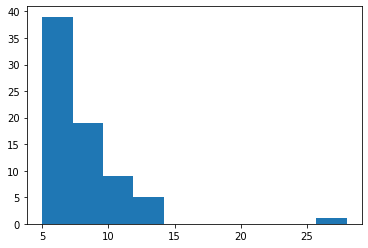

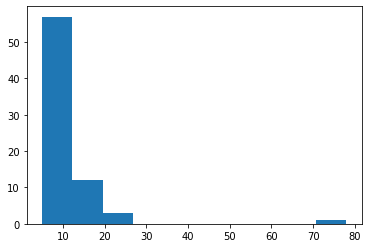

[14.  6. 11.  8.  6.  7.  6.  8.  9.  7.  6. 13. 11. 12.  7. 11.  9.  9.
 10. 10.  9.  9. 12.  9.  8.  9. 13.  8.  9.  7.  7. 28. 10.  6.  7.  6.
  8.  5. 11.  8. 10.  8. 10.  6.  7.  7.  6.  8.  6.  5.  6.  5.  5.  5.
  6.  6.  6.  6.  6.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  9.  8.  7.
  8.] [26.  8. 17. 12.  7.  9.  9. 11. 13.  9.  7. 23. 15. 15. 10. 16. 12. 11.
 13. 13. 12. 11. 16.  9. 10. 12. 19. 10. 10. 12.  9. 78. 12.  8.  9.  8.
 11.  6. 22. 11. 18. 11. 18.  8.  9.  7.  8. 11.  8.  6.  7.  6.  7.  6.
  7.  7.  7.  7.  7.  6.  7.  6.  6.  6.  7.  7.  7.  5.  6. 14.  8. 10.
 12.]


In [11]:
# First definition of complexity is just the total number of terms
complexity1 = np.sum(number_nonlinear_terms, axis=-1)
plt.figure()
plt.hist(complexity1)
plt.show()

# Second definition of complexity is the terms weighted by the polynomial order
weights = np.ones((num_attractors, 5)) 
for i in range(num_attractors):
    weights[i, :] = weights[i, :] * np.array([0, 1, 2, 3, 4])
complexity2 = np.sum(number_nonlinear_terms * weights, axis=-1)
plt.figure()
plt.hist(complexity2)
plt.show()
print(complexity1, complexity2)

### Another test... does PySINDy performance depend on how multi-scale the system is?
Can measure this through the ratio of the largest and smallest coefficients in the system, if system is nondimensionalized.